In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from tensorflow.keras.models import Model
import pandas as pd
import tensorflow as tf
import scipy.io as sio
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, UpSampling2D, concatenate
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as Ks
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
import os
import utilModels
from keras_flops import get_flops
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [3]:
modelName = 'U_Net_Dice_Loss_Inner_with_Papilary'
name_save_directory = "U_Net_Dice_Loss_Inner_with_Papilary"
saving_metrics = 'Metrics_UU_Net_Dice_Loss_Inner_with_Papilary.csv'


results = "_Results"
images = "_Joint_Images"
parent_directory = "/tank/data/navchetan/Lars_Annotated_Datasets/Results/"
saveFolder = os.path.join(parent_directory,name_save_directory)
# os.mkdir(saveFolder)

name_save_results_directory = name_save_directory+results
path_results_save = os.path.join(saveFolder,name_save_results_directory)
# os.mkdir(path_results_save)

name_save_images_directory = name_save_directory+images
path_images_save = os.path.join(saveFolder,name_save_images_directory)
# os.mkdir(path_images_save)



In [4]:
def customLoss(yTrue,yPred):
    return (1e4)*(Ks.mean(Ks.square(yPred - yTrue), axis=-1))


IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
N_TRAIN_SAMPLES = 1445
CHANNELS = 1
N_EVALUATE_SAMPLES = 475
N_TESTING_SAMPLES = 342
EVALUATE_FROM = 1
EPOCHS = 100
LEARNING_RATE = 0.0001
F = 64

In [5]:
def CustomImgGenSC(path_train_input,path_train_output,indlst_train,\
                   df_train_input,df_train_output,\
                   H=256,W=256,onlyX=False,shuffle=False,BATCH_SIZE=16):
    L_train = len(indlst_train)
    while True:
        if(shuffle):
            random.shuffle(indlst_train)
        ii = 0 # Current image index
        left = L_train
        while left>0:
            BL = min(BATCH_SIZE,left)
            X_BATCH = np.zeros((BL,H,W,1))
            Y_BATCH = np.zeros((BL,H,W,1))
            for bi in range(BL):
                os.chdir(path_train_input)
                imgIdx = indlst_train[ii] 
                pathr = 'Image'+str(imgIdx).zfill(5)+'.mat'
                x = sio.loadmat(pathr)
                X_BATCH[bi,:,:,0] = x['U']/255.0           
                
                if(not onlyX):
                    os.chdir(path_train_output)
                    pathr = 'Segment'+str(imgIdx).zfill(5)+'.mat'
                    x = sio.loadmat(pathr)
                    Y_BATCH[bi,:,:,0] = x['S']/255.0
                ii+=1
                
            left = left - BL
            if(not onlyX):
                yield (X_BATCH,Y_BATCH)
            else:
                yield X_BATCH

In [6]:
path_train_input = "/tank/data/navchetan/Lars_Annotated_Datasets/Training_Input"
path_train_output = "/tank/data/navchetan/Lars_Annotated_Datasets/Training_Inner_With_Papillary"
path = "/tank/data/navchetan/Lars_Annotated_Datasets/"
os.chdir(path)
indlist_train_input = list(pd.read_csv('Training_indices.csv')['Indices'].values)
csvFileTrain_Input = 'Training_Input.csv'
df_train_input = pd.read_csv(csvFileTrain_Input)
csvFileTrain_Output = 'Training_Output.csv'
df_train_output = pd.read_csv(csvFileTrain_Output)
BS = 8

In [7]:
train_generator = CustomImgGenSC(path_train_input,path_train_output,indlist_train_input\
                                 ,df_train_input,df_train_output\
                                 ,H=256,W=256,onlyX=False,shuffle=False,BATCH_SIZE=BS)

In [8]:
path_validation_input = "/tank/data/navchetan/Lars_Annotated_Datasets/Validation_Input"
path_validation_output = "/tank/data/navchetan/Lars_Annotated_Datasets/Validation_Inner_With_Papillary"
path = "/tank/data/navchetan/Lars_Annotated_Datasets/"
os.chdir(path)
indlist_validation_input = list(pd.read_csv('Validation_indices.csv')['Indices'].values)
# indlist_validation_output = list(pd.read_csv('Training_indices.csv')['Indices'].values)
csvFilevalidation_Input = 'Validation_Input.csv'
df_validation_input = pd.read_csv(csvFilevalidation_Input)
csvFilevalidation_Output = 'Validation_Output.csv'
df_validation_output = pd.read_csv(csvFilevalidation_Output)
BS = 16

In [9]:
validation_generator = CustomImgGenSC(path_validation_input,path_validation_output,indlist_validation_input\
                                 ,df_validation_input,df_validation_output\
                                 ,H=256,W=256,onlyX=False,shuffle=False,BATCH_SIZE=BS)

In [10]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
batch_size = 8
N_TRAIN=len(indlist_train_input)
N_VALIDATE=len(indlist_validation_input)
# N_TEST=len(indlist_testing_input)
    
t_steps = math.ceil(N_TRAIN/batch_size)
v_steps = math.ceil(N_VALIDATE/batch_size)
# tt_steps = math.ceil(N_TEST/batch_size)

min_lr=0.0001
epochs=300
LR_patience=20
LR_factor=0.1
stop_patience=50
retrainFlag=False

modelSave = saveFolder + '/' + modelName + '.h5'
trainGraphSave = saveFolder + '/' + modelName+ '_training_plot.png'

callbacks = [EarlyStopping(patience=stop_patience, verbose=1),
                 ReduceLROnPlateau(factor=LR_factor, patience=LR_patience, min_lr=min_lr, verbose=1),
                 ModelCheckpoint(modelSave, verbose=1, save_best_only=True, save_weights_only=False)]

In [3]:
H = 256
W = 256
input_img = Input((H,W,1),name='img')
model = utilModels.get_unet_large(input_img, n_filters = 32, dropout = 0.0, batchnorm = True)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
flops = get_flops(model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 27.3 G


In [13]:
# def dice_loss1(y_true, y_pred):
#   y_true = tf.cast(y_true, tf.float64)
#   y_pred = tf.math.sigmoid(y_pred)
#   numerator = 2 * tf.reduce_sum(y_true * y_pred)
#   denominator = tf.reduce_sum(y_true + y_pred)

#   return 1 - numerator / denominator

In [14]:
import tensorflow.keras.backend as K
def generalized_dice_coefficient(y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

In [15]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss= dice_loss, metrics=["accuracy"]) 
results = model.fit_generator(train_generator, steps_per_epoch=t_steps,  epochs=epochs,use_multiprocessing=False, 
                                  workers=0,validation_data=validation_generator,validation_steps=v_steps,callbacks=callbacks, shuffle=False)

Epoch 1/300


KeyboardInterrupt: 

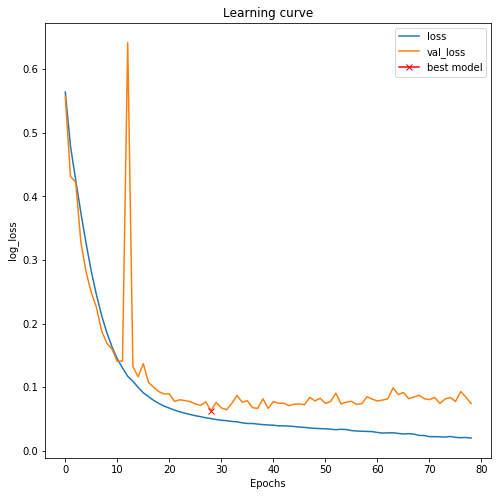

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [16]:
import os
import math
import pandas as pd
path_testing_input = "/tank/data/navchetan/Lars_Annotated_Datasets/Testing_Input"
path_testing_output = "/tank/data/navchetan/Lars_Annotated_Datasets/Testing_Inner_With_Papillary"
path = "/tank/data/navchetan/Lars_Annotated_Datasets/"
os.chdir(path)
indlist_testing_input = list(pd.read_csv('Testing_indices.csv')['Indices'].values)
# indlist_validation_output = list(pd.read_csv('Training_indices.csv')['Indices'].values)
csvFiletesting_Input = 'Testing_Input.csv'
df_testing_input = pd.read_csv(csvFiletesting_Input)
csvFiletesting_Output = 'Testing_Output.csv'
df_testing_output = pd.read_csv(csvFiletesting_Output)
BS = 8

N_PRED=len(indlist_testing_input)
pred_steps= math.ceil(N_PRED/batch_size)
    


pred_X_generator = CustomImgGenSC(path_testing_input,path_testing_output,indlist_testing_input\
                                 ,df_testing_input,df_testing_output\
                                 ,H=256,W=256,onlyX=True,shuffle=False,BATCH_SIZE=BS)
    
# path = "/data/navchetan/Data/Testing"
# os.chdir(path)

# Create and save result matrix batch by batch
a = 0
print('Running prediction Steps.. ' + str(pred_steps))
count = 1
for step in range(pred_steps): 
    pred_Y_predict = model.predict_generator(pred_X_generator,steps=1,use_multiprocessing=False,workers=0)
    print(step,end=" ")
    b = np.shape(pred_Y_predict)[0]
    short_lst = indlist_testing_input[a:a+b]
    a+=b
    pos = 0
    os.chdir(path_results_save)
    for i in short_lst:
        S = pred_Y_predict[pos,:,:,0]
        fsave = 'Segment_Output'+str(count).zfill(5)+'.mat'
        sio.savemat(fsave, {'S':S})
        pos+=1
        count = count + 1

Running prediction Steps.. 43
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

In [16]:
import os
import pandas as pd
import scipy.io as sio
import cv2
import numpy as np
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix


cols = ['sensitivity','specificity','accuracy','dice_score','Jaccard']
df = pd.DataFrame(columns=cols)
path_testing_ground_truth = "/tank/data/navchetan/Lars_Annotated_Datasets/Testing_Inner_With_Papillary"
N_TESTING_SAMPLES = 342
print('Loading Testing Data for computation of Jaccard Index')
sensitivity_t = 0
specificity_t = 0
accuracy_t = 0
dice_score_t = 0
Jaccard_t = 0
for i in range(N_TESTING_SAMPLES):
    if(i%10 == 0):
        print(i)
    os.chdir(path_results_save)    
    pathr = 'Segment_Output'+str(i+1).zfill(5)+'.mat'
    x = sio.loadmat(pathr)
    Segment_model = x['S']
    Segment_model1 = Segment_model*255;
    retval1, Segment_model_threshold = cv2.threshold(Segment_model1,100,255,cv2.THRESH_BINARY)
    Segment_model_threshold1 = Segment_model_threshold/255.0
    
    os.chdir(path_testing_ground_truth)
    path_t = 'Segment'+str(i+1).zfill(5)+'.mat'
    y = sio.loadmat(path_t)
    ground_truth_testing  = y['S']
    ground_truth1 = ground_truth_testing*255;
    retval2, ground_truth_testing_threshold = cv2.threshold(ground_truth1,0,255,cv2.THRESH_BINARY)
    ground_truth_testing_threshold1 = ground_truth_testing_threshold/255.0

    mcm = confusion_matrix(np.ndarray.flatten(Segment_model_threshold1),np.ndarray.flatten(ground_truth_testing_threshold1))
    tn = mcm[0, 0]
    fp = mcm[0, 1]
    fn = mcm[1, 0]
    tp = mcm[1, 1]
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    dice_score = 2*tp / (2*tp + fp + fn)
    Jaccard = dice_score / (2-dice_score)
    
    sensitivity_t = sensitivity_t + sensitivity
    specificity_t = specificity_t + specificity
    accuracy_t = accuracy_t + accuracy
    dice_score_t = dice_score_t + dice_score
    Jaccard_t = Jaccard_t + Jaccard
    
    
    df = df.append(pd.Series([sensitivity,specificity,accuracy,dice_score,Jaccard],index=df.columns), ignore_index=True)

os.chdir(saveFolder)
df.to_csv(saving_metrics,index=False)
print(sensitivity_t/N_TESTING_SAMPLES)
print(specificity_t/N_TESTING_SAMPLES)
print(dice_score_t/N_TESTING_SAMPLES)
print(accuracy_t/N_TESTING_SAMPLES)
print(Jaccard_t/N_TESTING_SAMPLES)

Loading Testing Data for computation of Jaccard Index
0
10
20
30
40
50


KeyboardInterrupt: 

In [17]:
O1 = np.zeros((N_TESTING_SAMPLES,256,256))
O2 = np.zeros((N_TESTING_SAMPLES,256,256))
Ground_Truth = np.zeros((N_TESTING_SAMPLES,256,256))
Segmentation_from_model = np.zeros((N_TESTING_SAMPLES,256,256))

path = "/tank/data/navchetan/Lars_Annotated_Datasets/Testing_Input"
os.chdir(path)
for i in range(N_TESTING_SAMPLES):
    if(i%10 == 0):
        print(i)
    pathr = 'Image'+str(i+1).zfill(5)+'.mat'
    x = sio.loadmat(pathr)
    O1[i,:,:] = x['U']/255
    O2[i,:,:] = x['U']/255
    
path = "/tank/data/navchetan/Lars_Annotated_Datasets/Testing_Inner_With_Papillary"
os.chdir(path)
for i in range(N_TESTING_SAMPLES):
    if(i%10 == 0):
        print(i)
    pathr = 'Segment'+str(i+1).zfill(5)+'.mat'
    x = sio.loadmat(pathr)
    Ground_Truth[i,:,:] = x['S']
    retval2, ground_truth_testing_threshold = cv2.threshold(Ground_Truth[i,:,:],0,255,cv2.THRESH_BINARY)
    Ground_Truth[i,:,:] = ground_truth_testing_threshold/255.0
    

os.chdir(path_results_save)
for i in range(N_TESTING_SAMPLES):
    if(i%10 == 0):
        print(i)
    pathr = 'Segment_Output'+str(i+1).zfill(5)+'.mat'
    x = sio.loadmat(pathr)
    Segmentation_from_model[i,:,:] = x['S']
    Segment_model1 = Segmentation_from_model[i,:,:]*255;
    retval1, Segment_model_threshold = cv2.threshold(Segment_model1,100,255,cv2.THRESH_BINARY)
    Segmentation_from_model[i,:,:] = Segment_model_threshold/255.0
 
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    [ha,wa] = np.shape(imga)
    [hb,wb] = np.shape(imgb)
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img


h = 256
w = 256
img_array = []    
for k in range(N_TESTING_SAMPLES):
    print(k)
    for i in range(h):
        for j in range (w):
            if Ground_Truth[k,i,j]>0:
                O1[k,i,j]=Ground_Truth[k,i,j]
            if Segmentation_from_model[k,i,j]>0:
                O2[k,i,j]=Segmentation_from_model[k,i,j]
    W1 = O1[k,:,:]
    W2 = O2[k,:,:]
    img = concat_images(W1,W2)
    img_array.append(img)
    
    os.chdir(path_images_save) 
    pathr = 'Joint_Image'+str(k+1).zfill(5)+'.png'
    cv2.imwrite(pathr, img*255) 

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180